In [33]:
import torch
import IPython
import torch.utils
import torch.distributions
import torchvision    
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
import math

In [34]:
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200
z_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)


**2 C**

In [35]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.to_mean_logvar = nn.Linear(512, 2 * latent_dims)
        
    def reparametrization_trick(self, mu, log_var):
        # Using reparameterization trick to sample from a gaussian
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps
    
    def forward(self, x, return_parameters=False):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        
        if return_parameters:
          return mu, log_var
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reparametrization_trick(mu, log_var)


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)        
        return self.decoder(z)


def train(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

In [36]:
vae = VariationalAutoencoder(z_dim).to(device) # GPU
vae = train(vae, data_loader, epochs=20)

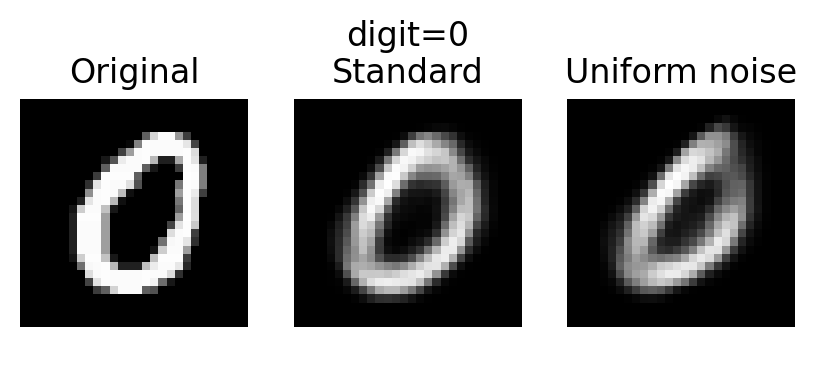

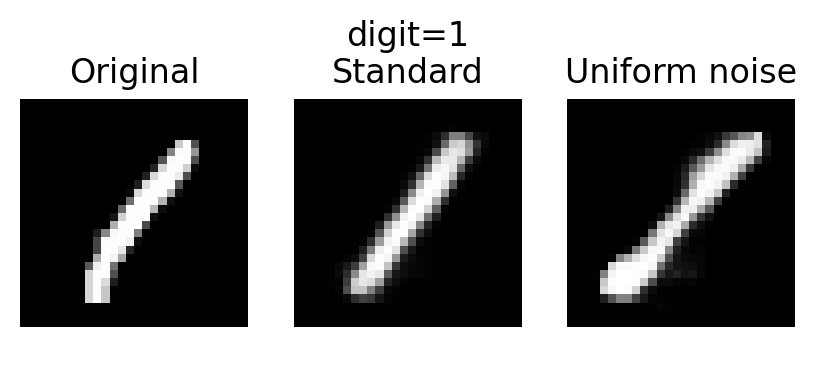

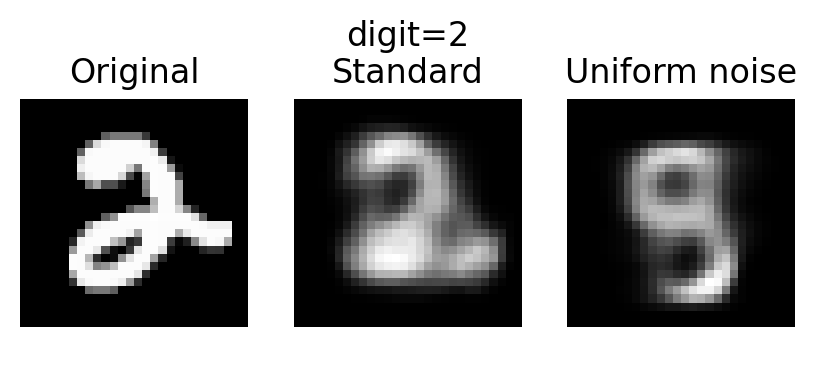

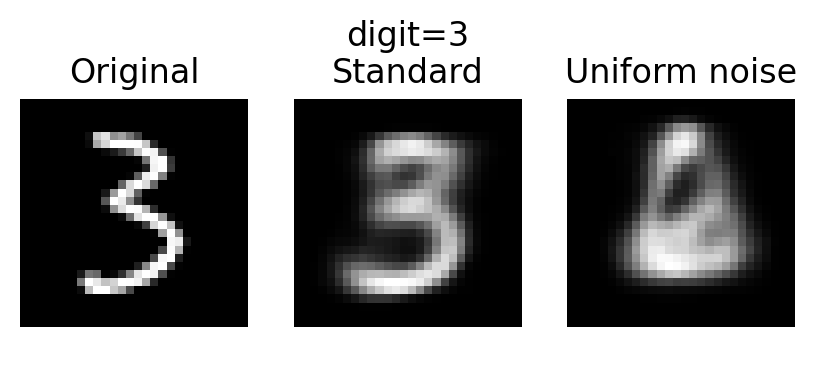

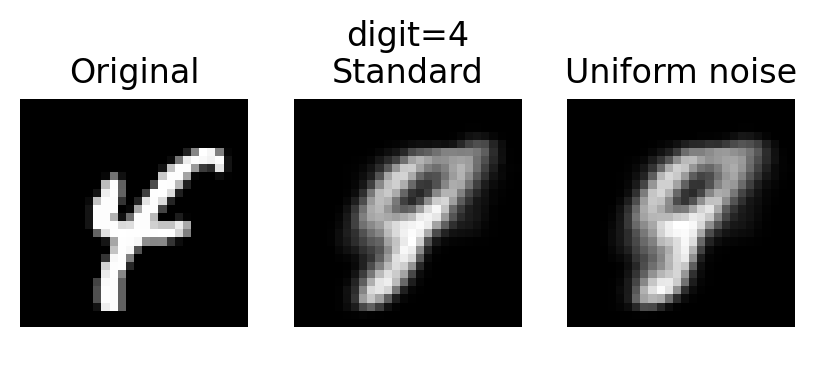

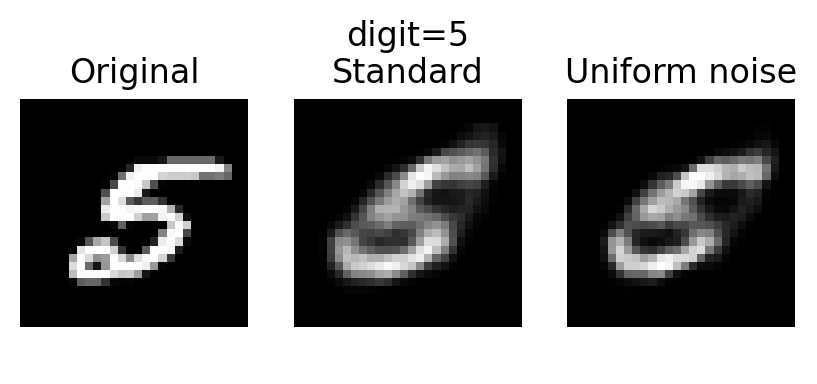

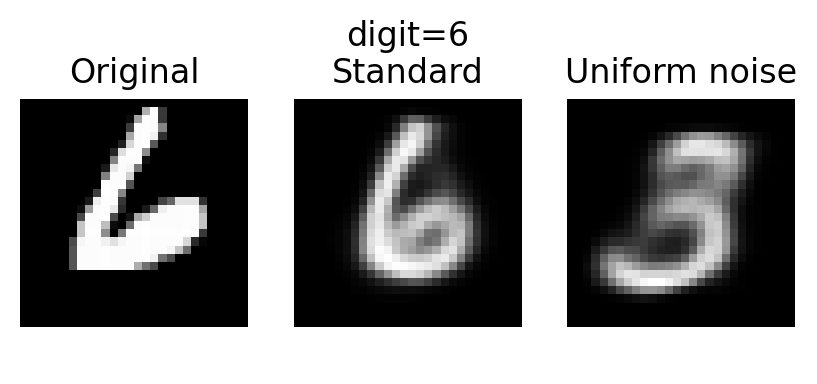

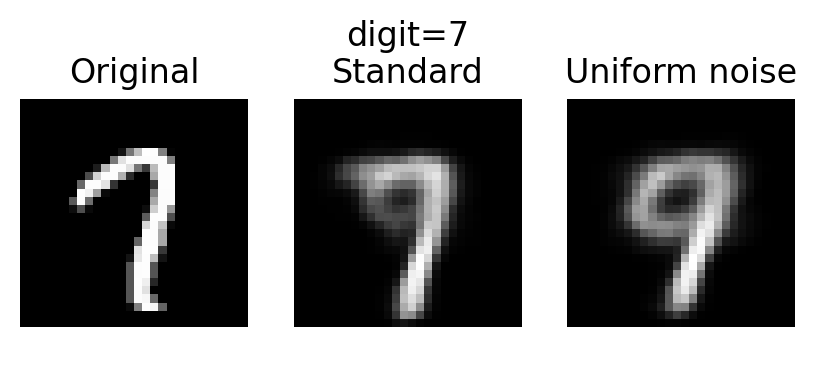

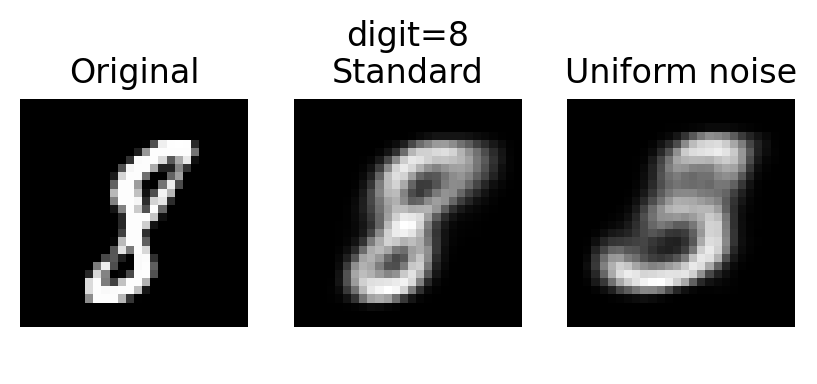

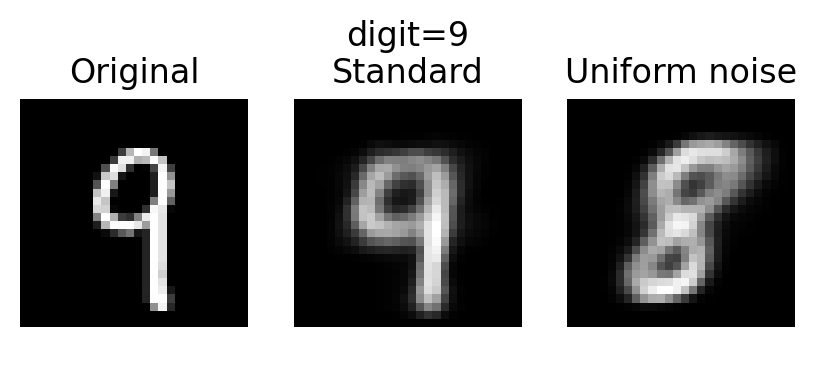

In [37]:
for digit in range(10):
  for x, y in data_loader:
    for i, sample in enumerate(y):
      if sample == digit:
        x = x[i].to(device) 
        mu, log_var = vae.encoder.forward(x, True)
        epsilon = np.random.uniform(low=-1, high=1, size=2)
        latent_1 = np.random.normal(float(mu[0][0]) + epsilon[0], math.exp(float(log_var[0][0]) / 2))
        latent_2 = np.random.normal(float(mu[0][1]) + epsilon[1], math.exp(float(log_var[0][1]) / 2))
        latent = torch.Tensor([latent_1, latent_2])
        x_uni = vae.decoder.forward(latent)
        x_std = vae.forward(x)

        fig = plt.figure(figsize=(5, 2))
        plt.axis('off')
        plt.title(f"digit={digit}")

        fig.add_subplot(1, 3, 1)
        plt.imshow(x.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Original")
          
        fig.add_subplot(1, 3, 2)
        plt.imshow(x_std.detach().numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Standard")

        fig.add_subplot(1, 3, 3)
        plt.imshow(x_uni.detach().numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Uniform noise")
        break
    break

**2 D**

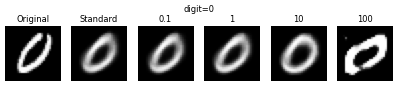

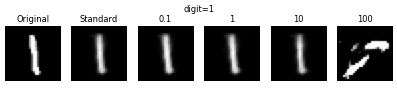

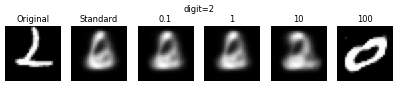

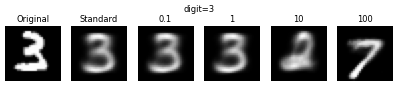

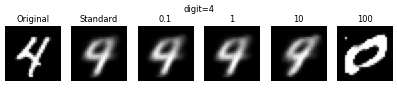

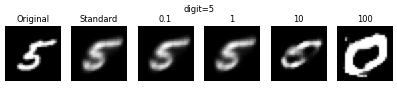

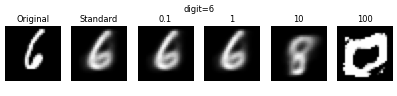

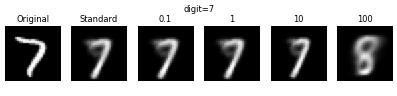

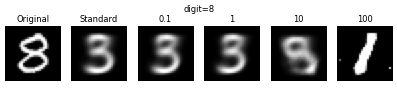

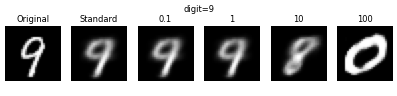

In [41]:
plt.rcParams['figure.dpi'] = 50
for digit in range(10):
  for x, y in data_loader:
    for i, sample in enumerate(y):
      if sample == digit:
        x = x[i].to(device)
        x_standard = vae.forward(x)
        mu, log_var = vae.encoder.forward(x, True)
        latent_variables = [vae.decoder.forward(torch.Tensor([np.random.normal(float(mu[0][0]), sd_mult * math.exp(float(log_var[0][0]) / 2)), 
                            np.random.normal(float(mu[0][1]), sd_mult * math.exp(float(log_var[0][1]) / 2))])) for sd_mult in [0.1, 1, 10, 100]]


        fig = plt.figure(figsize=(10, 2))
        plt.axis('off')
        plt.title(f"digit={digit}")

        fig.add_subplot(1, 6, 1)
        plt.imshow(x.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Original")
          
        fig.add_subplot(1, 6, 2)
        plt.imshow(x_standard.detach().numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Standard")

        for i, mult in enumerate([0.1, 1, 10, 100]):  
          fig.add_subplot(1, 6, 3 + i)
          plt.imshow(latent_variables[i].detach().numpy().squeeze(), cmap='gray')
          plt.axis('off')
          plt.title(mult)
        break
    break

**2 E**

In [42]:
def train_reconstruction(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            loss.backward()
            opt.step()
    return vae

def train_KL(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            loss = vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

In [43]:
vae_reconstruction = VariationalAutoencoder(z_dim).to(device)
vae_reconstruction = train_reconstruction(vae_reconstruction, data_loader, epochs=20)

vae_KL = VariationalAutoencoder(z_dim).to(device) 
vae_KL = train_KL(vae_KL, data_loader, epochs=20)

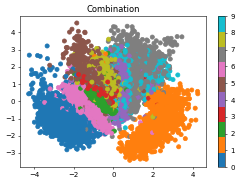

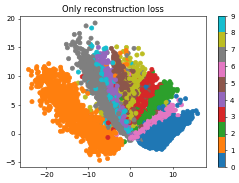

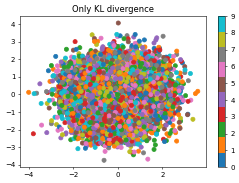

In [44]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

losses = ["Combination", "Only reconstruction loss", "Only KL divergence"]
models = [vae, vae_reconstruction, vae_KL]
for i, model in enumerate(models):
  plot_latent(model, data_loader)
  plt.title(losses[i])
  plt.show()